(a)
Let X be the number of points in T that map to the same bucket as z under a random hash function gi.

Then, X is a random variable that follows a binomial distribution with parameters |Wj| and p = Pr[gj(x) = gj(z)].

So, E[X] = |Wj|p and we can use Markov's inequality to bound Pr(X >= 3).
Pr(X >= 3) = Pr(X >= 3E[X]/E[X]) <= E[X]/3E[X] = 1/3

By the union bound, the probability that there exists a j for which |T ∩ Wj| < 3 is at most L/3.

Therefore, the probability that there exists a bucket that has less than 3 points in T and maps to the same bucket as z is at most L/3.

(b)
Let x∗ be the point in the dataset such that d(x∗, z) ≤ λ.

Pr[gj(x∗) != gj(z)] = 1 - Pr[gj(x∗) = gj(z)]

For gj to map x∗ to the same bucket as z, all k hash functions in gj must map x∗ and z to the same bucket.

Since gj is (λ, cλ, p1, p2)-sensitive, Pr[gj(x) = gj(z)] <= p1 if d(x,z) <= λ, and Pr[gj(x) = gj(z)] <= p2 if d(x,z) <= cλ.

Therefore, Pr[gj(x∗) = gj(z)] >= 1 - p1^k - (1 - p2^k)^(n-1)

Using the inequality 1 - x <= e^(-x), we have

Pr[gj(x∗) = gj(z)] >= 1 - e^(-k/p1 * ln n) - e^(-k/p2 * ln n)

Taking the union bound over all L hash functions, we have

Pr[∀1 <= j <= L, gj(x∗) != gj(z)] <= L * (1 - e^(-k/p1 * ln n) - e^(-k/p2 * ln n))
 
 (c)
To show that the reported point is an actual (c, λ)-ANN with constant probability, we need to prove that the probability of not finding an (c, λ)-ANN is bounded by some constant. Let P be the probability of not finding an (c, λ)-ANN.

We know that the probability of a point being hashed into a particular bucket is at most p1. Therefore, the probability of a point not being hashed into a particular bucket is at least 1 − p1. The probability that a query point z is not hashed into a particular bucket is at most (1 − p1)^L. Hence, the probability that a query point is hashed into a particular bucket is at least 1 − (1 − p1)^L.

Since the procedure retrieves at most 3L data points from the set of L buckets to which the query point hashes, the probability of not retrieving the nearest point with distance at most cλ is at most (1 − (1 − p1)^L)^(3L).
We want to bound the above probability by some constant. Using the binomial theorem, we have (1 − x)^n ≤ e^(-nx) for any x ∈ [0, 1]. Applying this to our case, we have

P ≤ (1 − (1 − p1)^L)^(3L) ≤ e^(-3L(1-p1)^L) ≤ e^(-3p1^L).
Therefore, P is bounded by e^(-3p1^L), which is a constant when L is fixed. Hence, the probability of not finding an (c, λ)-ANN is bounded by a constant.


In [12]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
#Modified: Alex Porter
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import itertools
from collections import OrderedDict
from statistics import mean

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
  dist = np.linalg.norm(u-v)
  return dist
     
# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data():
  filename = '/content/drive/MyDrive/patches.csv'
  return np.genfromtxt(filename, delimiter=',')
A = load_data()
     
# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset in which each row is an image patch.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k, L):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)
functions,hashed_A = lsh_setup(A,24, 10)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A,query_index,num_neighbors):
    distances = {}
    for i in range(len(A)):
        if query_index == i:
            continue
        else:
            distance = l1(A[i],A[query_index])
            distances.update({i:distance})
    sorted_distances = OrderedDict(sorted(distances.items(), key=lambda x: x[1]))
    return dict(itertools.islice(sorted_distances.items(), num_neighbors))



##1) Average Search time for LSH and Linear Search.


In [13]:
query_indices = [100,200,300,400,500,600,700,800,900,1000]
lshresults = []
lsresults = {}
endtimelsh = []
endtimels = []
for i in query_indices:
    start_time_lsh = time.time()
    lsh_search_result = lsh_search(A,hashed_A,functions,i,10)
    end_time_lsh = time.time()
    time_elapsed_lsh = (end_time_lsh - start_time_lsh)
    endtimelsh.append(time_elapsed_lsh)
    lshresults.append(lsh_search_result)
    start_time_ls = time.time()
    linear_search_result = linear_search(A,i,10)
    end_time_ls = time.time()
    time_elapsed_ls = (end_time_ls - start_time_ls)
    endtimels.append(time_elapsed_ls)
    lsresults.update({i:linear_search_result})
    print("LSH",lsh_search_result)
    print(time_elapsed_lsh)
    print("--------------------------------------------------------")
    print("Linear Search",linear_search_result)
    print(time_elapsed_ls,"\n")
print("\n\n")
print("The average runtime for LSH Search : ", mean(endtimelsh))
print("The average runtime for Linear Search : ", mean(endtimels))

LSH [8196, 10123, 10873, 16007, 14710, 7464, 42395, 23398, 18531, 12444]
0.18990087509155273
--------------------------------------------------------
Linear Search {8196: 502.3136470373864, 28351: 505.9456492549373, 21780: 517.2774883947686, 14383: 521.3616786838097, 37765: 523.9093433028276, 24374: 524.8466442685901, 18866: 527.2570530585627, 28251: 528.7210985009015, 25289: 531.9389062664998, 10123: 532.4030428162483}
0.5882713794708252 

LSH [41237, 3259, 29385, 3247, 35700, 52040, 52071, 52014, 348, 29849]
0.1616365909576416
--------------------------------------------------------
Linear Search {39581: 750.484510166599, 3692: 758.9993412381858, 41588: 761.4151298733169, 15314: 767.2098800198027, 3618: 768.7808530394082, 1888: 768.8751524142265, 11611: 769.5238787718026, 52134: 771.5996371175922, 51943: 772.1696704740481, 28688: 774.5998967208814}
0.5623927116394043 

LSH [8410, 16448, 17578, 22509, 26780, 7449, 42471, 54243, 8198, 13931]
0.2284083366394043
-------------------------

##2) Plot for error values vs L and error value vs K

In [15]:
# TODO: Write a function that computes the error measure
def lsh_error(hashed_A,functions):
    query_indices = [100,200,300,400,500,600,700,800,900,1000]
    error = 0
    for j in query_indices:
        lsh_dist = 0
        lshSearch = lsh_search(A,hashed_A,functions,j,3)
        #print(lshSearch)
        for x in lshSearch:
            lshDist = l1(A[j],A[x])
            lsh_dist+=lshDist
        linear_dist = 0
        linearSearchDict = linear_search(A,j,3)
        linearSearch = list(linearSearchDict.keys())
        #print(linearSearch)
        for y in linearSearch:
            linearDist = l1(A[j],A[y])
            linear_dist+=linearDist
        error+=(lsh_dist/linear_dist)
    return error/10    


In [16]:
#Calculating the error values when k=24 and L = [10,12,14,16,18,20]

k = 24
L = [10,12,14,16,18,20]
error = []
for i in L:
  functions,hashed_A = lsh_setup(A,k,i)
  err = lsh_error(hashed_A,functions)
  error.append(err)
print(error)

[1.0189080044414163, 1.0162462149930833, 1.0133378772933135, 1.0235216075017548, 1.0088494623565567, 1.0125386972777104]


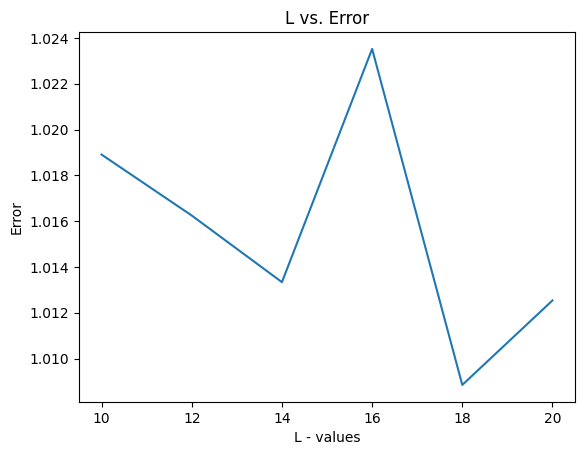

In [17]:
#Plotting the L vs Error graph:

plt.plot(L,error)
plt.xlabel('L - values')
plt.ylabel('Error')
plt.title('L vs. Error')
plt.show()

In [18]:
#Calulating the error values when L = 10 and k = [16,18,20,22,24]

L = 10
k = [16,18,20,22,24]
error = []
for i in k:
  functions,hashed_A = lsh_setup(A,i,L)
  err = lsh_error(hashed_A,functions)
  error.append(err)
print(error)

[1.0068146272453986, 1.0124483469435446, 1.022997720010126, 1.0145051534216007, 1.0273278332694427]


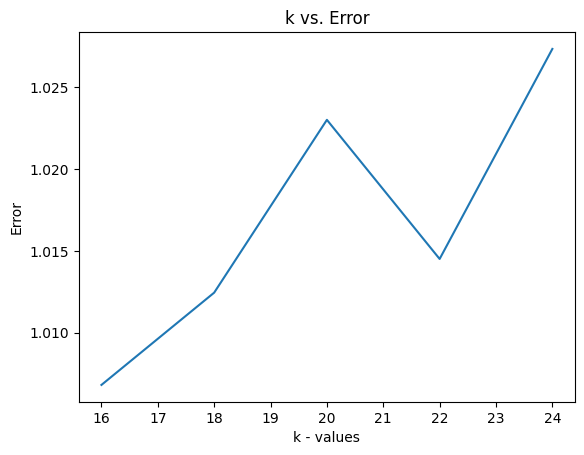

In [19]:
#Plotting the k vs. Error Graph

plt.plot(k,error)
plt.xlabel('k - values')
plt.ylabel('Error')
plt.title('k vs. Error')
plt.show()

##3) Plot the 10 nearest neighbors found by both methods.

In [20]:
lsh100 = lshresults[0:1]
print(lsh100)

ls = lsresults.get(100)
ls100 = list(ls.keys())

print(ls100)

[[8196, 10123, 10873, 16007, 14710, 7464, 42395, 23398, 18531, 12444]]
[8196, 28351, 21780, 14383, 37765, 24374, 18866, 28251, 25289, 10123]


In [21]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

In [22]:
#Retrieving images of 10 nearest neighbors using LSH

plot(A,lsh100[0],"lshpics")
     

In [23]:
og = [100]

In [24]:
# Plotting the original image

plot(A,og,"Original_img")